In [193]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import sys
from segment_anything import sam_model_registry, SamPredictor #v.1.0
import os
import pandas as pd
from sklearn.cluster import KMeans

In [194]:
#load sample image
image = cv2.cvtColor(cv2.imread('/workspace/gvData/segSamps/gv_seg/20220605231413_000097_Trim_frame2.jpg'), cv2.COLOR_BGR2RGB)

In [195]:
#get SAM model and trained checkpoint
sam_checkpoint = "/workspace/SAM_model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [196]:
#takes x and y centers from entire dataset
def reduce_points(centx,centy,k):
    points = [(centx[j], centy[j]) for j in range(0, len(centx))]

    #perform k-means to reduce 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(points)


    kCents = kmeans.cluster_centers_
    x,y = zip(*kCents) #disconnect points from tuple
    
    return x,y

def SAM_segment(rgb_image, kmpx,kmpy, predictor):
    #segment with SAM model
    
    predictor.set_image(rgb_image)
    input_point = np.array([[i*rgb_image.shape[1],j*rgb_image.shape[0]] for i,j in zip(kmpx,kmpy)])
    input_label = np.array([1]*len(kmpx))    
    
    masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )

    best_mask = masks[np.argmax(scores), :, :]  # Choose the model's best mask
    bin_mask = best_mask.astype(int)
    return bin_mask

In [197]:
#get seeds from litter locations
labelCSV = r"/workspace/gvData/segSamps/Training02.csv"

centx = []
centy = []

#annotations file
df_antt = pd.read_csv(labelCSV)

xmin = df_antt["xmin"].values
ymin = df_antt["ymin"].values
xmax = df_antt["xmax"].values
ymax = df_antt["ymax"].values
width = df_antt["width"].values #width and height of IMAGES
height = df_antt["height"].values

for i, name in enumerate(xmin):
    xcen = float((xmin[i] + xmax[i])) / 2 / width[i] #normalise bboxes for yolo according to image size (YOLO is in format <class> <x centroid> <y centroid> <bb width> <bb height>)
    ycen = float((ymin[i] + ymax[i])) / 2 / height[i]
    
    centx.append(xcen)
    centy.append(ycen)

In [198]:
#get segment
#create uniform segment from all litter points
#get union of both

In [199]:
#Reduce points
x,y = reduce_points(centx,centy,40)
mask = SAM_segment(image,x,y,predictor)

In [228]:
#Code for copy-paste
taco_path = r"/workspace/TACO/TACO/TACO-master/data"

#get image and mask according to image ID
#takes path of TACO data and list of image IDs
def getTaco(p, imIds):   
    ann_path = os.path.join(p, "annotations.json")
    coco = COCO(ann_path)
    
    litIms = []
    litMasks = []
    for imId in imIds: #for each image selected
        #get image object from coco annotations
        img = coco.imgs[imId]
        
        #get file name and join it to data path
        imp = os.path.join(p, img['file_name'])
        
        #get category ids
        cat_ids = coco.getCatIds()
        #get annotation ids
        anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        
        #load taco image
        im = cv2.cvtColor(cv2.imread(imp),cv2.COLOR_BGR2RGB)
        
        #for each annotation....
        
        for i, ann in enumerate (anns):
            mask = coco.annToMask(anns[i])

            #crop image and mask
            img_h,img_w,c = im.shape


            [x,y,w,h] = anns[i]['bbox']
            cropped_img = im[int(y):int(y+h), int(x):int(x+w),  :]
            cropped_mask = mask[int(y):int(y+h), int(x):int(x+w)]

            #Cutout rubbish using mask
            cut_img = cv2.bitwise_and(cropped_img,cropped_img,mask = cropped_mask)
        
        #add to array of samples
        litIms.append(cut_img)
        litMasks.append(cropped_mask)
        
    return litIms, litMasks

    
#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    new_w = dim[0]
    new_h = dim[1]
    
    # return the resized image
    return resized, new_w, new_h

#combine litter and subsection of an image -> x1 and y1 are top-left of litter bounding box (top left cropped sample)
def combine(litter_im, litter_mask, verge, x1, y1, rotate = False):
    #Add images together
    
    #if rotate ==True, randomly rotate (possibility of no rotation '0' degrees)
    if rotate:
        angle = random.choice([-90,0,90,180])
        if angle == -90:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_90_COUNTERCLOCKWISE)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif angle == 90:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_90_CLOCKWISE)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_90_CLOCKWISE)
        elif angle ==180:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_180)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_180)
            
    #https://www.binarystudy.com/2022/09/How-to-add-subtract-different-size-images-using-OpenCV-Python.html#:~:text=Alternatively%20you%20can%20use%20cv2.addWeighted%20%28%29%20to%20add,cv2.addWeighted%20%28img11%2C%200.3%2C%20img22%2C%200.7%2C%200%29%20plt.imshow%20%28img_add%29

    # Find the minimum height and width of the two images
    min_height = litter_im.shape[0]
    min_width = litter_im.shape[1]

    # Crop images with minimum height and width
    foreground = litter_im
    background = verge[y1-min_height:y1, x1:x1+min_width]
    

    (Rb, Gb, Bb) = cv2.split(background)
    (Rf, Gf, Bf) = cv2.split(foreground)


    #invert mask
    inv_mask = 1-litter_mask


    #In each colour channel, cut out mask and add foreground channels
    
    Rn = cv2.bitwise_and(Rb,Rb,mask=inv_mask) + Rf
    Gn = cv2.bitwise_and(Gb,Gb,mask=inv_mask) + Gf
    Bn = cv2.bitwise_and(Bb,Bb,mask=inv_mask) + Bf

    #merge channels back together
    merged = cv2.merge([Rn,Gn,Bn])
    
    verge[y1-min_height:y1,x1:x1+min_width] = merged
    
    return verge, min_width, min_height #min width and min height are returned incase of rotation (Swaps points)


(1080, 1920)
(1080, 1920, 3)


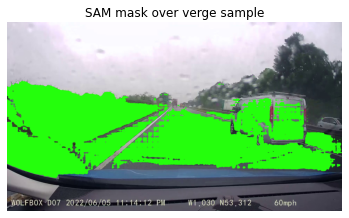

In [203]:
print(reMask.shape)
print(image.shape)
showMask = image.copy()
showMask[mask==1] = (36,255,12)
plt.axis('off')
plt.title("SAM mask over verge sample")
plt.imshow(showMask)

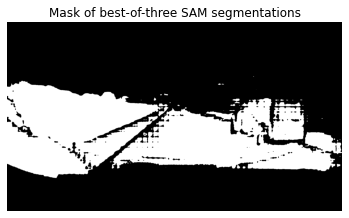

In [204]:
#show mask
reMask = np.squeeze(mask)
plt.axis('off')
plt.title("Mask of best-of-three SAM segmentations")
plt.imshow(reMask,cmap = 'gray')

Text(0.5, 1.0, 'Eroded mask over verge sample')

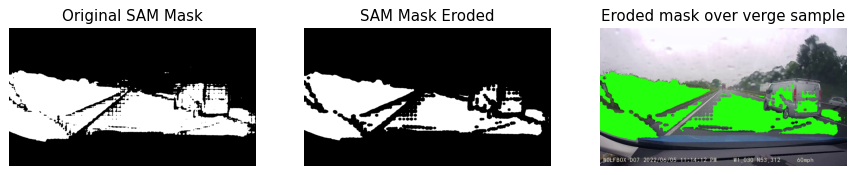

In [217]:
# #Erode mask such that placements dont ovelap over non-
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), dpi=90, sharey=False, squeeze= True)
# ax = ax.flatten()
# [az.axis("off") for az in np.ravel(ax)]

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# newMask =cv2.erode(reMask.astype('uint8'), kernel, iterations=5)

# showMask = image.copy()
# showMask[newMask==1] = (36,255,12)


# ax[0].imshow(reMask,cmap='gray'); ax[1].imshow(newMask,cmap='gray');ax[2].imshow(showMask);
# ax[0].set_title("Original SAM Mask");ax[1].set_title("SAM Mask Eroded"); ax[2].set_title("Eroded mask over verge sample")

In [263]:
#Get Mask as list of points
mpy, mpx = np.where(newMask==1)

(1080, 1920, 3)


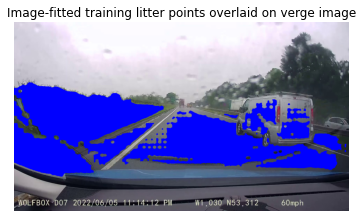

In [264]:
plotted_im = image.copy()
print(plotted_im.shape)

for i in range(0,len(mpx)):
    cv2.circle(plotted_im, (mpx[i],mpy[i]), radius=3, color=(0, 0, 255), thickness=-1)

plt.axis('off')
plt.title("Image-fitted training litter points overlaid on verge image")
plt.imshow(plotted_im)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


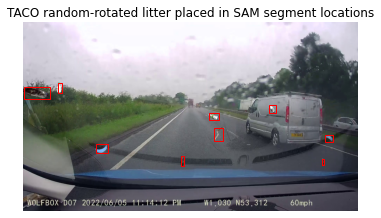

In [260]:
import random
import matplotlib.patches as patches
#place along random training points WITH RANDOM ROTATION WITHIN SAM SEGMENT
#get height & width of verge
vh = image.shape[0]; vw = image.shape[1]
#placement x must be between (0: vw- litter height)
#placement y must be between (0: vh- litter width)

#get cropped taco image and mask
ims, masks = getTaco(taco_path,[0,1,2,3,4,5,6,7,8])

merged = image.copy()

fig, ax = plt.subplots()


pointlen = len(mpx)
for i, litSamp in enumerate(ims):
    
    new_lit_height = random.randint(30,70)# height for litter resizing

    #resize litter to height 100
    context_cut, w , h = image_resize(ims[i],height=new_lit_height) ; context_mask,_,_ = image_resize(masks[i],height=new_lit_height)
    
    
    rand = random.randint(0,pointlen) #random points from training data
    locx = int(mpx[rand]-(w/2))#to place in centre, need to provide top-left point (-w, +h)
    locy = int(mpy[rand]+(h/2))
    
    
    #Check if points within image (object-permitting)
    if locx > vw-w:
        locx = vw-w
        
    if locx < 0:
        locx = 0
        
    if locy > vh-h:
        locy = vh-h
    
    if locy < 0:
        locy = 0

    #combine with background
    merged, nw, nh = combine(context_cut, context_mask, merged, locx , locy, rotate=True)

    rect = patches.Rectangle((locx, locy-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)




plt.axis('off')
plt.title("TACO random-rotated litter placed in SAM segment locations")
plt.imshow(merged)


#FIX COMBINE FUNCTION MIN_HEIGHT WHEN CROPPING IN ALL FILES!!!